### Python functions to perform Visual Impact Assessment (VIA)
- Siddharth Ramavajjala, Department of Geography, University of Wisconsin - Madison

In [1]:
import geopandas as gpd
import pandas as pd
from shapely import Point
import matplotlib.pyplot as plt

In [2]:
# Read United States Wind Turbine Database CSV file
# URL: https://www.sciencebase.gov/catalog/item/6001e327d34e592d8671fae0 (from USGS)
gdf = gpd.read_file("datasets/uswtdb.csv")
# Analyze and understand meaning columns
gdf.head(1)

,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,p_year,...,t_ttlh,retrofit,retrofit_year,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat,geometry
0,3123233,40-097764,2021-WTW-7887-OE,,,OK,Ellis County,40045,25 Mile Creek,2022,...,180,0,,1,3,1/4/2023,Digital Globe,-99.775963,36.458096,None


In [3]:
# geom() return Point object based on longitude('xlong') and latitude('ylat')
def geom(x):
    """Function to create a Point geometry object and insert into GeoDatFrame"""
    return Point(x['xlong'], x['ylat'])
# Update the geometry column using lambda function
gdf["geometry"] = gdf.apply(lambda x: geom(x), axis=1)
# Print head to check if the column is updated correctly
gdf.head(1)

In [4]:
# gdf.crs property check whether a coordinate reference system (CRS) is assigned
if gdf.crs == None:
    print("No CRS")

No CRS


In [5]:
# If no CRS is assigned, use EPSG:4326 as long, lat values are in 3 Dimensional coordinate system
gdf = gdf.set_crs('epsg:4326')
# Use gdf.explore() to interactively map and view the point locations of wind turbines

In [6]:
# Print unique state values for scoping
gdf['t_state'].unique()

array(['OK', 'CA', 'IA', 'MA', 'OH', 'MN', 'IL', 'NE', 'WY', 'KS', 'PA',
       'TX', 'IN', 'NC', 'NM', 'NH', 'MI', 'NY', 'ND', 'SD', 'CO', 'HI',
       'PR', 'NJ', 'WV', 'OR', 'AK', 'WA', 'MT', 'ME', 'AR', 'RI', 'WI',
       'MO', 'VT', 'TN', 'ID', 'UT', 'VA', 'MD', 'AZ', 'GU', 'CT', 'NV',
       'DE'], dtype=object)

In [7]:
# Print count of unique counties to scope magnitude of dataset
gdf['t_county'].nunique()

569

In [8]:
# Create a dictionary and store Wind Turbine count corresponding to each state
print("State \t Wind Turbine Count")
wtb_dict = {}
for state in list(gdf['t_state'].unique()):
    print(f'{state}:{gdf["t_state"].value_counts()[state]}')
    wtb_dict[state] = gdf["t_state"].value_counts()[state]

State 	 Wind Turbine Count
OK:5474
CA:5989
IA:6293
MA:92
OH:499
MN:2744
IL:3622
NE:1523
WY:1463
KS:3962
PA:752
TX:18552
IN:1614
NC:105
NM:1952
NH:84
MI:1637
NY:1233
ND:2095
SD:1367
CO:2835
HI:129
PR:63
NJ:6
WV:419
OR:2122
AK:142
WA:1826
MT:809
ME:417
AR:1
RI:35
WI:452
MO:1107
VT:73
TN:18
ID:541
UT:208
VA:2
MD:80
AZ:321
GU:1
CT:3
NV:68
DE:1


In [9]:
# Sort the dictionary values in ascending order and store them back
sorted_wtb_counts = sorted(wtb_dict.items(), key=lambda x:x[1])
wtb_dict = dict(sorted_wtb_counts)

In [10]:
# Print to view wind turbine count by state in ascending order
wtb_dict

{'AR': 1,
 'GU': 1,
 'DE': 1,
 'VA': 2,
 'CT': 3,
 'NJ': 6,
 'TN': 18,
 'RI': 35,
 'PR': 63,
 'NV': 68,
 'VT': 73,
 'MD': 80,
 'NH': 84,
 'MA': 92,
 'NC': 105,
 'HI': 129,
 'AK': 142,
 'UT': 208,
 'AZ': 321,
 'ME': 417,
 'WV': 419,
 'WI': 452,
 'OH': 499,
 'ID': 541,
 'PA': 752,
 'MT': 809,
 'MO': 1107,
 'NY': 1233,
 'SD': 1367,
 'WY': 1463,
 'NE': 1523,
 'IN': 1614,
 'MI': 1637,
 'WA': 1826,
 'NM': 1952,
 'ND': 2095,
 'OR': 2122,
 'MN': 2744,
 'CO': 2835,
 'IL': 3622,
 'KS': 3962,
 'OK': 5474,
 'CA': 5989,
 'IA': 6293,
 'TX': 18552}

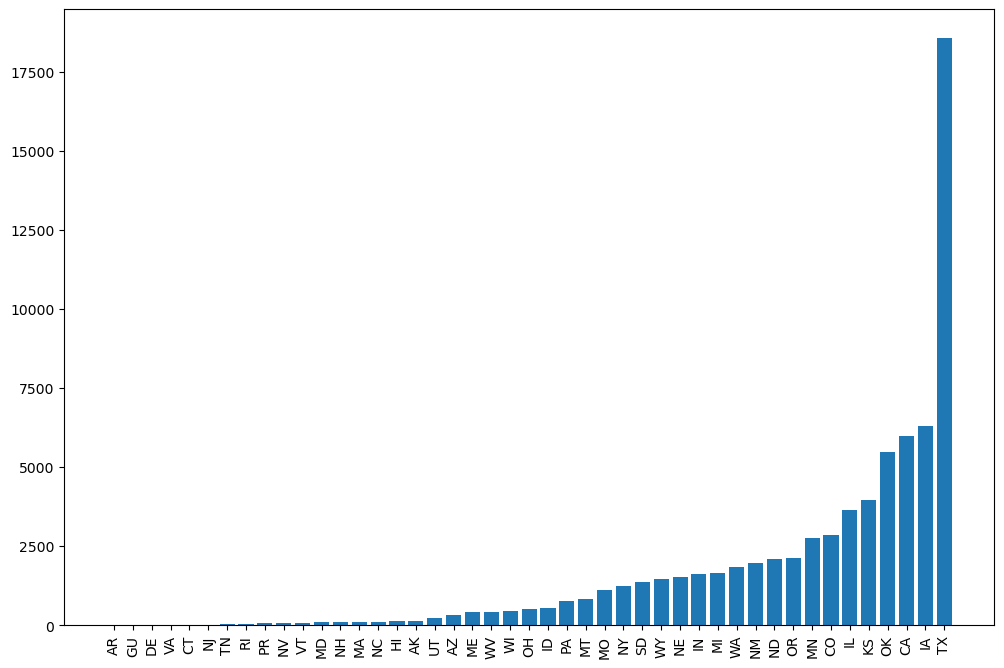

In [11]:
# Plot bar chart for ranking each state
plt.bar(list(wtb_dict.keys()), list(wtb_dict.values()))
# Adjust the rotation angle to 90 degrees (To avoid label clutter)
plt.xticks(rotation=90)  
# Adjust the figure size to increase spacing between labels
plt.gcf().set_size_inches(12, 8)  # Adjust the width and height as needed
# Show the plot
plt.show()

In [12]:
# Create an ESRI output shapefile (after setting projection to EPSG:4326)
gdf.to_file("datasets/uswtdb.shp")

C:\Users\Sidrcs\AppData\Local\Temp\ipykernel_19340\2761893381.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("datasets/uswtdb.shp")


In [26]:
gdf_tx_aoi = gdf[(gdf['t_state']=='TX') & (gdf['t_county']=='Bee County') & (gdf['p_name']=='Blackjack Creek')]

### Wind Turbines in Texas

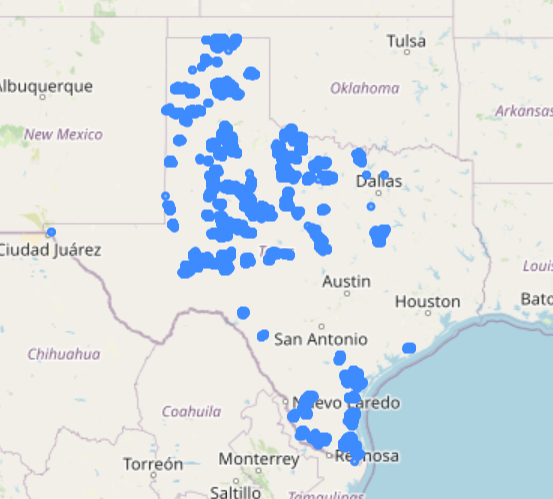

In [33]:
print(f'Xmax:{gdf_tx_aoi["xlong"].max()} \tYmax:{gdf_tx_aoi["ylat"].max()} \nXmin:{gdf_tx_aoi["xlong"].min()} \tYmin:{gdf_tx_aoi["ylat"].min()}')

Xmax:-97.573631 	Ymax:28.308331 
Xmin:-97.461571 	Ymin:28.221092


Click here <a href = "https://apps.nationalmap.gov/downloader/#/">USGS TNM Downloader</a>  to download the DEM data using bounding box coordinates (aforementioned)

In [29]:
gdf_tx_aoi.columns.values

array(['case_id', 'faa_ors', 'faa_asn', 'usgs_pr_id', 'eia_id', 't_state',
       't_county', 't_fips', 'p_name', 'p_year', 'p_tnum', 'p_cap',
       't_manu', 't_model', 't_cap', 't_hh', 't_rd', 't_rsa', 't_ttlh',
       'retrofit', 'retrofit_year', 't_conf_atr', 't_conf_loc',
       't_img_date', 't_img_srce', 'xlong', 'ylat', 'geometry'],
      dtype=object)

In [28]:
gdf_tx_aoi.head(1)

,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,p_year,...,t_ttlh,retrofit,retrofit_year,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat,geometry
5071,3119713,48-186736,2019-WTW-9999-OE,,,TX,Bee County,48025,Blackjack Creek,2022,...,185.5,0,,1,3,2/17/2022,Digital Globe,-97.565788,28.285681,POINT (-97.56579 28.28568)


In [39]:
import rasterio as rio
from rasterio.plot import show

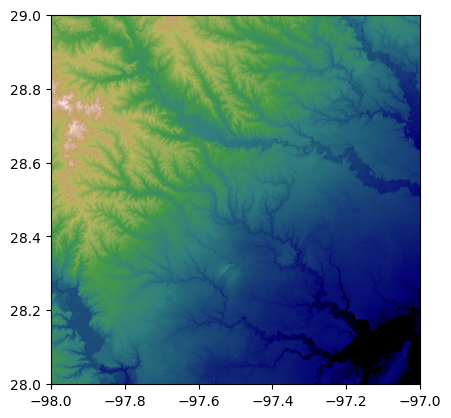

In [41]:
with rio.open('datasets/USGS_13_n29w098_20211103.tif') as dst:
    show(dst, cmap = 'gist_earth')

In [42]:
with rio.open('datasets/USGS_13_n29w098_20211103.tif') as dst:
    meta = dst.meta.copy()

In [43]:
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -999999.0,
 'width': 10812,
 'height': 10812,
 'count': 1,
 'crs': CRS.from_epsg(4269),
 'transform': Affine(9.259259269220166e-05, 0.0, -98.00055555629325,
        0.0, -9.259259269220166e-05, 29.000555555895062)}